# This notebook fits the ICS correlation function to a simple Gaussian
Note that you need to have moviecorr.tif from the sim_movie simulation (or from experimental data) loaded into your workspace.
Click here to open in google colab: http://colab.research.google.com/github/jayunruh/pysimfcs/blob/main/fit_ics.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
import os
if(not os.path.exists('pysimfcs_utils.py')):
    print('downloading pysimfcs libraries')
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/pysimfcs_utils.py
if(not os.path.exists('analysis_utils.py')):
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/analysis_utils.py
else:
    print('libraries already downloaded')

libraries already downloaded


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import analysis_utils as simutils
import pandas as pd
import scipy.optimize as so
import tifffile

In [3]:
#first read in the correlation images
corr=tifffile.imread('moviecorr.tif')
#crop the correlation to the central 32 pixels
halfsize=corr.shape[-1]//2
print(halfsize)
corr=corr[:,halfsize-16:halfsize+16,halfsize-16:halfsize+16]
corr.shape

32


(3, 32, 32)

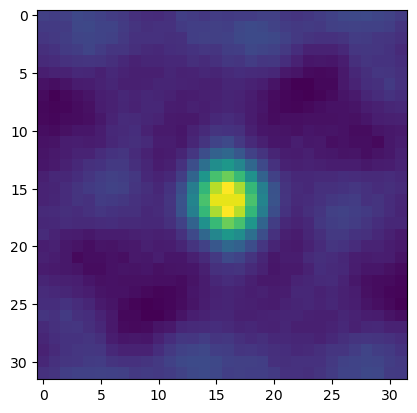

In [4]:
plt.imshow(corr[0])

In [5]:
base=0.5*(corr[0,0].mean()+corr[0,-1].mean())
print('background estimate',base)
g0=corr[0].max()-base
print('g0 estimate',g0)

background estimate 0.009276606646728226
g0 estimate 0.14223161221478423


In [11]:
#set up the metadata and the initial fitting parameters
simutils.centerx=16
simutils.centery=16
simutils.fitxpts=32
simutils.fitypts=32
#parameters are baseline,G0,w0
gparams=[0.0,0.15,3.4]
llims=[gparams[0]-0.5,gparams[1]/3.0,gparams[2]/3.0]
ulims=[gparams[0]+0.5,gparams[1]*3.0,gparams[2]*3.0]
#make the xvalues (repeated x axis)
fitxvals=np.tile(np.arange(32),32)
profiles=corr[0].flatten()

In [12]:
fparams,fcov=so.curve_fit(simutils.gausfunc,fitxvals,profiles,
             p0=gparams,bounds=(llims,ulims),method='trf')

#the standard error methods utilizes the square root of the diagonal of the covariance matrix
ferrs=np.sqrt(np.diag(fcov))
#now get the fit from the optimized parameters
fit=simutils.gausfunc(fitxvals,*fparams)
#and get the chi squared value
rchi2=((profiles-fit)**2).sum()/(len(profiles)-len(gparams))

In [13]:
print('Here are the best fit parameters:')
print(fparams)
print('Here are the errors (based on covariance):')
print(ferrs)

Here are the best fit parameters:
[-2.78374374e-03  1.68712698e-01  2.99532363e+00]
Here are the errors (based on covariance):
[0.00028293 0.00321747 0.04162264]


In [14]:
#now reshape the fit into an image
fitimg=fit.reshape((32,32))

Text(0.5, 1.0, 'residuals')

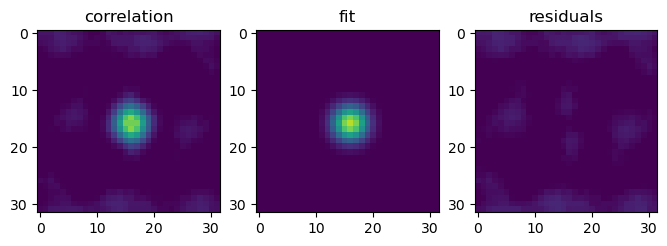

In [15]:
plt.figure(figsize=(8,3))
ax=plt.subplot(1,3,1)
ax.imshow(corr[0],vmin=0,vmax=1.1*fparams[1])
ax.set_title('correlation')
ax=plt.subplot(1,3,2)
ax.imshow(fitimg,vmin=0,vmax=1.1*fparams[1])
ax.set_title('fit')
ax=plt.subplot(1,3,3)
ax.imshow(corr[0]-fitimg,vmin=0,vmax=1.1*fparams[1])
ax.set_title('residuals')